In [1]:
# import all libraries 

import numpy as np
from ge.classify import read_node_label,Classifier
from ge import Node2Vec
from ge import DeepWalk
from ge import Exp
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
import random
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import community as comm
from math import floor
warnings.filterwarnings('ignore')



In [2]:
def node_classification(embeddings, label):
    X, Y = read_node_label(label,skip_head=True)
    
    ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
    for tf in ltrainfrac:
        if (tf == 0.2 or tf == 0.4):
            print("Training classifier using {:.2f}% nodes...".format(tf * 100))
        clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
        clf.split_train_evaluate(X, Y, tf)


        
        
def makeLinkPredictionData(graph, embeddings):
    # converting embedding to a numpy array
    X = [[0] for i in range(G.number_of_nodes())]
    for i in range(0, G.number_of_nodes()):
        X[i] = embeddings[str(i+1)]
    X = np.array(X)
    
    Xd = []
    Yd = []
    count = 0
    for u in range(graph.number_of_nodes()):
        Nu = list(graph.neighbors(u))
        count += len(Nu)
        cn = 0
        totalns = 0
        for n in Nu:
            x = []
            if n > u:
                for d in range(len(X[0])):
                    x.append(X[u][d] - X[n][d])
                Xd.append(x)
                Yd.append(1)
                totalns += 1
        tmpnn = []
        if len(Nu) > graph.number_of_nodes() // 2:
            totalns = (graph.number_of_nodes() - len(Nu)) // 2
            print("Testing neighbors!")
        while cn < totalns:
            nn = random.randint(0, graph.number_of_nodes() - 1)
            if nn not in Nu and nn not in tmpnn:
                cn += 1
                x = []
                for d in range(len(X[0])):
                    x.append(X[u][d] - X[nn][d])
                Xd.append(x)
                Yd.append(0)
                tmpnn.append(nn)
    Xd, Yd = np.array(Xd), np.array(Yd)
    indices = np.array(range(len(Yd)))
    np.random.shuffle(indices)
    Xt = Xd[indices]
    Yt = Yd[indices]
    #print(len(Xd), len(Yd), count)
    
    
    ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
    for tf in ltrainfrac:
        CV = int(len(Yt) * tf)
        trainX = Xt[0:CV]
        testX = Xt[CV:]
        trainY = Yt[0:CV]
        testY = Yt[CV:]
        modelLR = LogisticRegression().fit(trainX, trainY)
        predictedY = modelLR.predict(testX)
        acc = accuracy_score(predictedY, testY)
        f1macro = f1_score(predictedY, testY, average='macro', labels=np.unique(predictedY))
        f1micro = f1_score(predictedY, testY, average='micro', labels=np.unique(predictedY))
        print("Link predictions:", tf, ":Accuracy:",acc, "F1-macro:", f1macro, "F1-micro:",f1micro)


def cluster_eval(G, embeddings):
    # converting embedding to a numpy array
    X = [[0] for i in range(G.number_of_nodes())]
    #print(len(embeddings))
    #length = G.number_of_nodes() - 1
    #print(G.number_of_nodes())
    for i in range(0, G.number_of_nodes()):
        #print(G.number_of_nodes())
        X[i] = embeddings[str(i+1)]
    X = np.array(X)

    bestModularity = 0
    bestC = 2
    NOC = 30
    allmodularity = []
    for cls in range(2, NOC):
        
        # find clusters using a kmeans clustering algorithm on the embedding
        # Number of clusters is set to cls
        clusters = KMeans(n_clusters=cls, random_state=0).fit(X)
        predG = dict()
        for node in range(len(clusters.labels_)):
            predG[node] = clusters.labels_[node]
        
        # compute the modularity score of the Kmeans clustering
        modularity = comm.community_louvain.modularity(predG, G)
        allmodularity.append(modularity)
        print("Number of clusters: ", cls, "  Modularity: ", modularity)
        if modularity > bestModularity:
            bestModularity = modularity
            bestC = cls
    plt.scatter(range(2, NOC), allmodularity)
    plt.xlabel("Number of clusters")
    plt.ylabel("Modularity score")
    plt.show()
    #print("Best Modularity:",bestModularity, "Clusters:", bestC)

    
    
def plot_embeddings(embeddings, label):

    X, Y = read_node_label(label,skip_head=True)
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    color_idx = {}
    

    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.legend()
    plt.show()

In [3]:
clust_f= {}
clust_dic={}
def clust_coeff(G):
    global clust_f 
    global clust_dic
    
    clust_f= nx.clustering(G)
    #print(clust_f)
    for node,coeff in clust_f.items():
        if coeff in clust_dic:
            continue
        else:
            same_clust = {k for k,v in clust_f.items() if v == coeff}
            clust_dic[coeff]=same_clust


In [4]:
dgree = {}
same_degree_dic = {}
def degree(G):
    global dgree
    global same_degree_dic
    
    dgree = dict(G.degree())
    for node,deg in dgree.items():
        if deg in same_degree_dic:
            continue
        else:
            same_clust = {k for k,v in dgree.items() if v == deg}
            same_degree_dic[deg]=same_clust


In [5]:
metric = {}
same_metric_dic = {}
def metric_calc(G,met):
    global metric 
    global same_metric_dic
    
  
    if (met == "bc"):
        metric = dict(nx.betweenness_centrality(G))
        #b_cent_dic[centrality]=same_cent
        print("\nBetweeness Centrality")
    elif (met == "cc"):
        metric=nx.closeness_centrality(G)
        print("\nCloseness Centrality")
    elif (met == "ec"):    
        metric=nx.eigenvector_centrality(G)
        print("\nEigenvector Centrality")
    elif (met == "dg"):    
        metric = dict(G.degree())
        print("\nDegree")
    elif (met == "clust"):    
        metric = nx.clustering(G)
        print("\nClust")
    
    for node,met in metric.items():
        if met in same_metric_dic:
            continue
        else:
            same_cent = {k for k,v in metric.items() if v == met}
            same_metric_dic[met]=same_cent

In [6]:
avg_score = {}
avg_score_dict = {}

def metric_merging(G):
    global avg_score 
    global avg_score_dict 
    
    metric1 = nx.eigenvector_centrality(G)
    #metric2 = dict(G.degree())
    metric2 = nx.closeness_centrality(G)
    
    
    for k,v in metric1.items():
        if k in metric2:
            avg_score[k] = (v+metric2[k])/2
    
    for node,score in avg_score.items():
        if score in avg_score_dict:
            continue
        else:
            same_score = {k for k,v in avg_score.items() if v == score}
            avg_score_dict[score]=same_score

In [9]:
def get_embedding(G, algorithm,num_walks):
    #degree(G)
    #clust_coeff(G)
    metric_calc(G,algorithm)
    #print(b_cent_dic)
    metric2 = dict(G.degree())
    #metric = nx.clustering(G)
    #metric_merging(G)
    #print(avg_score)
    #print(avg_score_dict)
    
    if(algorithm == "deepwalk"):
        model = DeepWalk(G, walk_length=10, num_walks=80, workers=1)
    else:
        model = Node2Vec(G, 10, num_walks, workers=1,p=0.8,q=1,metric1=metric, same_metric1_dic=same_metric_dic, metric2=metric2)
        #model = Node2Vec(G, 10, num_walks, workers=1,p=0.25,q=2)
        #model = Node2Vec(G, 10, 80, workers=1,p=0.25,q=1,dgree=dgree, same_degree_dic=same_degree_dic)
   
    model.train(embed_size=500, window_size=5, iter=3)
    start = time.time()
    embeddings = model.get_embeddings()
    end = time.time()
    print("Time elapsed for embedding", end-start)
    return embeddings

In [10]:
import time

graphfile = 'data/Cora/cora.txt'
labelfile = 'data/Cora/cora.nodes.labels'
#graphfile = 'data/wiki/Wiki_edgelist.txt'
#labelfile = 'data/wiki/wiki_labels.txt'
#gaphfile = 'data/flight/brazil-airports.edgelist'
#labelfile = 'data/flight/labels-brazil-airports.txt'
#graphfile = 'data/git_web_ml/git_edges.txt'
#labelfile = 'data/git_web_ml/git_features.txt'

#G= nx.read_edgelist('data/git_web_ml/git_edges.txt', create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
#G= nx.read_edgelist('data/flight/brazil-airports.edgelist', create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
#G= nx.read_edgelist('data/wiki/Wiki_edgelist.txt', create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
G = nx.read_edgelist('data/Cora/cora.txt', create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])

#G = nx.read_edgelist('test.txt', create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
#G = nx.read_edgelist('data/Cora/cora.txt',nodetype=None)
G = G.to_directed()
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
#dict(islice(degree.iteritems(), 0, 2))
#print(dgree)
#print(clust_f)#
#Get embedding 128 dimension
#for i in range(80,160,80):
start = time.time()
embeddings = get_embedding(G,"ec",80)
end = time.time()

print("Time elapsed", end-start)
# plot the embedding 
#plot_embeddings(embeddings, labelfile)

Number of nodes:  2708
Number of edges:  5429

Eigenvector Centrality
randomwalk took:  8.344650268554688e-06
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 59.7min finished


Learning embedding vectors...
Learning embedding vectors done!
Time elapsed for embedding 0.014950990676879883
Time elapsed 3594.8330929279327


In [11]:
# Evaluate node classification from embedding 
node_classification(embeddings, labelfile)

-------------------
0.4188034188034188
-------------------
0.49548810500410173
Training classifier using 20.00% nodes...
-------------------
0.5599630996309963
-------------------
0.5907172995780591
Training classifier using 40.00% nodes...
-------------------
0.6150061500615006
-------------------
0.6233382570162481
-------------------
0.6439114391143912
-------------------
0.6560196560196561
-------------------
0.6789667896678967


Number of clusters:  2   Modularity:  0.18465502595299665
Number of clusters:  3   Modularity:  0.42264536628911853
Number of clusters:  4   Modularity:  0.4702575635155243
Number of clusters:  5   Modularity:  0.5179273399373752
Number of clusters:  6   Modularity:  0.5400351484372992
Number of clusters:  7   Modularity:  0.568582349951991
Number of clusters:  8   Modularity:  0.5797981597918878
Number of clusters:  9   Modularity:  0.6081803954757399
Number of clusters:  10   Modularity:  0.6127957413220901
Number of clusters:  11   Modularity:  0.6257829011615059
Number of clusters:  12   Modularity:  0.6092216312257863
Number of clusters:  13   Modularity:  0.6119873351616044
Number of clusters:  14   Modularity:  0.6127834644612158
Number of clusters:  15   Modularity:  0.6196044632348221
Number of clusters:  16   Modularity:  0.6294824721606026
Number of clusters:  17   Modularity:  0.617954158775852
Number of clusters:  18   Modularity:  0.6221789963443674
Number of clusters:  1

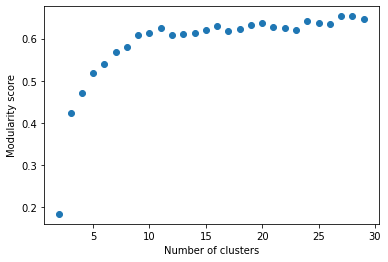

In [13]:
from scipy.io import mmread,mminfo
from community import community_louvain
filename = "data/Cora/cora.mtx"
#filename = "data/wiki/Wiki_edgelist.mtx"
#filename = "data/flight/brazil-airports.mtx"
g = mmread(filename)
nxG = nx.Graph(g)

cluster_eval(nxG, embeddings)

In [14]:
makeLinkPredictionData(nxG, embeddings) 

Link predictions: 0.05 :Accuracy: 0.5559876358560175 F1-macro: 0.5467204218321973 F1-micro: 0.5559876358560175
Link predictions: 0.1 :Accuracy: 0.5469950531522998 F1-macro: 0.5455432675778494 F1-micro: 0.5469950531522998
Link predictions: 0.2 :Accuracy: 0.5438721136767318 F1-macro: 0.5437103669343966 F1-micro: 0.5438721136767318
Link predictions: 0.3 :Accuracy: 0.5466847090663058 F1-macro: 0.5460047316075847 F1-micro: 0.5466847090663058
Link predictions: 0.4 :Accuracy: 0.5560467319229555 F1-macro: 0.5553760649281659 F1-micro: 0.5560467319229555
Link predictions: 0.5 :Accuracy: 0.5479348237968927 F1-macro: 0.5476255682830524 F1-micro: 0.5479348237968927
Link predictions: 0.6 :Accuracy: 0.5382429552450865 F1-macro: 0.5381994261119083 F1-micro: 0.5382429552450865
Link predictions: 0.7 :Accuracy: 0.5446795074202716 F1-macro: 0.5445519533104355 F1-micro: 0.5446795074202716
Link predictions: 0.8 :Accuracy: 0.5705492424242424 F1-macro: 0.5703711512000709 F1-micro: 0.5705492424242424
